In [1]:
!pip install torch numpy matplotlib scikit-learn


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [3]:
def generate_trajectory(seq_length=15, num_samples=6000):
    X = []
    Y = []

    for _ in range(num_samples):
        x, y = 0, 0
        trajectory = []

        angle = np.random.uniform(0, 2*np.pi)
        speed = np.random.uniform(0.05, 0.2)

        for _ in range(seq_length):
            x += speed * np.cos(angle)
            y += speed * np.sin(angle)
            angle += np.random.normal(0, 0.1)
            trajectory.append([x, y])

        trajectory = np.array(trajectory)

        X.append(trajectory[:10])   # Past 10 positions
        Y.append(trajectory[10:])   # Next 5 positions

    return np.array(X), np.array(Y)

X, Y = generate_trajectory()

print("Input Shape:", X.shape)
print("Output Shape:", Y.shape)


Input Shape: (6000, 10, 2)
Output Shape: (6000, 5, 2)


In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_train = torch.tensor(Y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
Y_test = torch.tensor(Y_test, dtype=torch.float32).to(device)


In [5]:
class TrajectoryLSTM(nn.Module):
    def __init__(self):
        super(TrajectoryLSTM, self).__init__()

        self.lstm = nn.LSTM(input_size=2,
                            hidden_size=64,
                            num_layers=2,
                            batch_first=True)

        self.fc = nn.Linear(64, 10)  # 5 future points * 2 coordinates

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out.view(-1, 5, 2)

model = TrajectoryLSTM().to(device)
print(model)


TrajectoryLSTM(
  (lstm): LSTM(2, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=10, bias=True)
)


In [6]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 50

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    output = model(X_train)
    loss = criterion(output, Y_train)

    loss.backward()
    optimizer.step()

    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")


Epoch [5/50], Loss: 1.428437
Epoch [10/50], Loss: 1.396496
Epoch [15/50], Loss: 1.343159
Epoch [20/50], Loss: 1.238253
Epoch [25/50], Loss: 1.025178
Epoch [30/50], Loss: 0.658487
Epoch [35/50], Loss: 0.312144
Epoch [40/50], Loss: 0.177323
Epoch [45/50], Loss: 0.190718
Epoch [50/50], Loss: 0.132179


In [7]:
model.eval()
with torch.no_grad():
    test_output = model(X_test)
    test_loss = criterion(test_output, Y_test)

print("Test Loss:", test_loss.item())


Test Loss: 0.12345786392688751


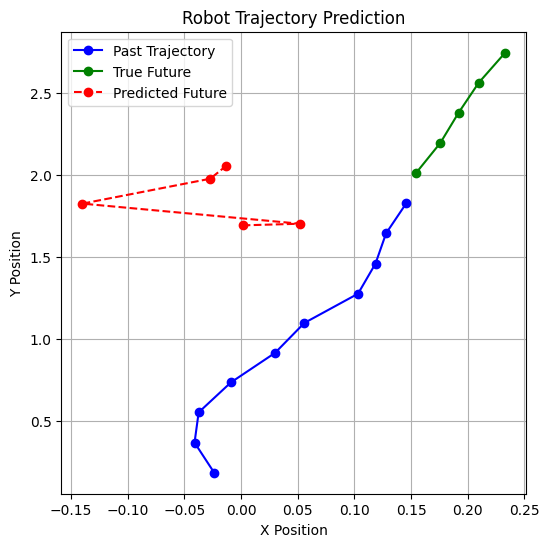

In [8]:
sample = 0

past = X_test[sample].cpu().numpy()
true_future = Y_test[sample].cpu().numpy()
pred_future = test_output[sample].cpu().numpy()

plt.figure(figsize=(6,6))

plt.plot(past[:,0], past[:,1], 'bo-', label='Past Trajectory')
plt.plot(true_future[:,0], true_future[:,1], 'go-', label='True Future')
plt.plot(pred_future[:,0], pred_future[:,1], 'ro--', label='Predicted Future')

plt.legend()
plt.title("Robot Trajectory Prediction")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.grid()
plt.show()
